<a href="https://colab.research.google.com/github/Bryan-Az/ContrastTransferLabs/blob/main/Supervised_Contrastive_Learning/SCL_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

github_path: Supervised_Contrastive_Learning/SCL_CV.ipynb

# Supervised Contrastive Learning in Computer Vision

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
import keras
from keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import losses

# Preparing the Data

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Data Augmentation Pipeline
This augmentation pipeline consists of a sequential model with neural network layers that apply transformations onto the input data to increase the data's underlying patterns. Normalization is applied onto the weight's contained within the model to make the inputs initially equally contribute to the output of the next layers. RandomFlip applies a random horizontal flip to some images, and RandomRotation applies a 2% rotation on the images to avoid overfitting the model on angles that are overly represented within the data.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

# The Supervised Contrastive Learning Model: Encoding & Classification Sub-Models

In [ ]:
from tensorflow.keras.callbacks import Callback

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    '''
    this is the supervised contrastive loss function for image classification
    it performs better than cross-entropy loss (typically used in classification)
    '''
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature
    @tf.function
    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        loss = tfa.losses.npairs_loss(tf.squeeze(labels), logits)
        return loss

def create_encoder():
    '''
    this function loads a residual network without the top layers and returns a keras model
    that can be used for encoding images.
    '''
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model

def add_projection_head(encoder):
    '''
    takes as input an encoder model (created using the prev. defined create_encoder() function)
    and returns a new model with a projection head.
    encoder: keras.Model
    '''
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

class LossHistory(Callback):
    def __init__(self):
        self.losses = []  # List to store losses

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            self.losses.append(logs.get('loss'))  # Append loss

## A Dimensionality-reducing Image Encoder Model

In [ ]:
encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 10
dropout_rate = 0.5
temperature = 0.05

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564807 (89.89 MB)
Trainable params: 23519360 (89.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________


In [ ]:
# pre-training the encoder prior to setting the classifier
# it is preferable to train using a GPU, ETA: 15 minutes
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate), # a gradient descent optimizer with momentum
    loss=SupervisedContrastiveLoss(temperature), # the contrastive loss is applied within the encoder
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, callbacks=[LossHistory()]
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functiona  (None, 2048)              23564807  
 l)                                                              
                                                                 
 dense_11 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23827079 (90.89 MB)
Trainable params: 23781632 (90.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________
Epoch 1/10
189/189 [==============================] - 39s 91ms/step - loss: 5.3293
Epoch 2/10
189/189 [==============================] - 17s 91ms/step - loss: 5.0675
Epoch 3/10
189/189

In [ ]:
# Retrieve the recorded losses
saved_losses = history.history['loss']

In [ ]:
saved_losses

[5.329336166381836,
 5.067535400390625,
 4.924575328826904,
 4.805604457855225,
 4.692788600921631,
 4.595344543457031,
 4.525373458862305,
 4.446011066436768,
 4.386149883270264,
 4.330236434936523]

### Visualizing the Loss of the trained Encoder

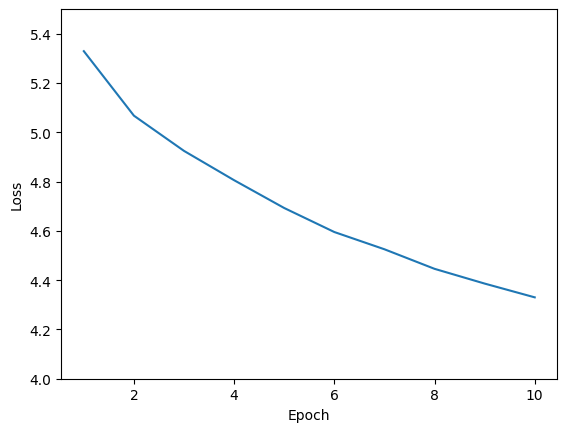

In [ ]:
import matplotlib.pyplot as plt
# plotting the saved_losses, each bin of 189 losses is an epoch, flattened
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, saved_losses)
# crop the range of y to 4-5.5
plt.ylim(4,5.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## The Classifier Model

In [ ]:
def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, callbacks=[LossHistory()])

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/10
189/189 [==============================] - 8s 24ms/step - loss: 0.7137 - sparse_categorical_accuracy: 0.7772
Epoch 2/10
189/189 [==============================] - 4s 23ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.7908
Epoch 3/10
189/189 [==============================] - 4s 24ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7931
Epoch 4/10
189/189 [==============================] - 4s 24ms/step - loss: 0.6265 - sparse_categorical_accuracy: 0.7932
Epoch 5/10
189/189 [==============================] - 4s 24ms/step - loss: 0.6247 - sparse_categorical_accuracy: 0.7934
Epoch 6/10
189/189 [==============================] - 4s 24ms/step - loss: 0.6194 - sparse_categorical_accuracy: 0.7943
Epoch 7/10
189/189 [==============================] - 4s 24ms/step - loss: 0.6158 - sparse_categorical_accuracy: 0.7955
Epoch 8/10
189/189 [==============================] - 5s 24ms/step - loss: 0.6173 - sparse_categorical_accuracy: 0.7943
Epoch 9/10
189/189 [====================

### Visualizing the Loss of the Trained Encoder & Classifier Combo

In [ ]:
classifier_losses = history.history['loss']

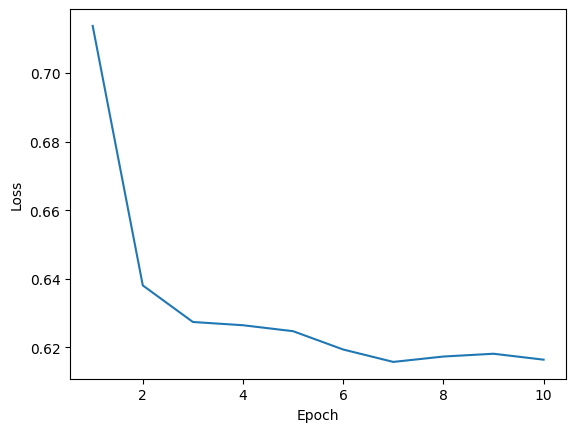

In [ ]:
import matplotlib.pyplot as plt
# plotting the saved_losses, each bin of 189 losses is an epoch, flattened
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, classifier_losses)
# crop the range of y to 4-5.5
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Conclusion
In the SCL image classification notebook, the final model accuracy and loss after 10 epochs of training is around 79% and 0.61, respectively.

In this non-SCL image classification notebook, the final model accuracy and loss after 10 epochs of training is around 77% and 0.67, respectively.

This shows that the SCL architecture has the ability to improve the performance of a model trained for image classification when compared to the traditional baseline architecture. Although I only trained the two models for 10 epochs each - further training may show a bigger difference between the two models.